<a href="https://colab.research.google.com/github/Berkay86/DeepPerson/blob/main/S%C4%B1n%C4%B1fland%C4%B1rma1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import string
from numpy import array
from keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer


In [221]:
resturantreviews = pd.read_csv("sentiment (2).csv")
resturantreviews.isnull().values.any()
resturantreviews.shape

(5001, 13)

In [222]:
resturantreviews.head()

,Unnamed: 0,Date,ID,url,username,source,location,tweet,num_of_likes,num_of_retweet,Processed_Tweets,Polarity,Sentiment
0,0,2022-12-13 21:45:05+00:00,1602781682041511936,https://twitter.com/thegreekgeekk/status/16027...,thegreekgeekk,Twitter for iPhone,Canada,@CouRageJD Even if Messi doesn’t win the World...,0,0,even if messi doesn ’ t win the world cup this...,0.22,Positive
1,1,2022-12-13 21:45:05+00:00,1602781679218737152,https://twitter.com/topqozym/status/1602781679...,topqozym,Twitter for iPhone,NaN,@PoojaMedia Morocco or France ...,0,0,morocco or france world cup we be lift by arge...,0.00,Positive
2,2,2022-12-13 21:45:05+00:00,1602781678971256832,https://twitter.com/ManCityToUcl/status/160278...,ManCityToUcl,Twitter for iPhone,"Liverpool, England",@FIFAWorldCup Benfica player,0,0,benfica player,0.00,Positive
3,3,2022-12-13 21:45:04+00:00,1602781676156895232,https://twitter.com/Fatiachra/status/160278167...,Fatiachra,Twitter for iPhone,NaN,Chedira is a good person who tried to make the...,0,0,chedira is a good person who tried to make the...,0.14,Positive
4,4,2022-12-13 21:45:04+00:00,1602781675448324096,https://twitter.com/SagafAbubakar/status/16027...,SagafAbubakar,Twitter Web App,lombok utara,@Thenotoriousne2 @FIFAWorldCup benched,0,0,benched,0.00,Positive


In [223]:
resturantreviews["tweet"][3]

"Chedira is a good person who tried to make the Moroccans happy by achieving a goal but he wasn't unable to score it. Instead of bullying and laughing at him try to encourage him he may be better in the coming days. He doesn't deserve all the hate was directed at him. #WorldCup https://t.co/pRLqjxGEKh"

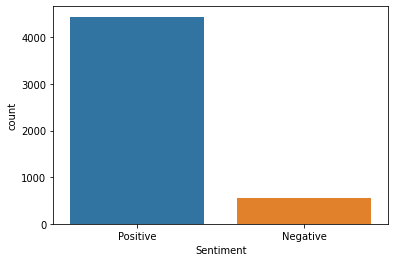

In [224]:
import seaborn as sns
sns.countplot(x='Sentiment', data=resturantreviews)
plt.show()

In [225]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [226]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [227]:
X = []
sentences = list(resturantreviews['tweet'])
for sen1 in sentences:
    X.append(preprocess_text(str(sen1)))

In [228]:
y = resturantreviews['Sentiment']
y = np.array(list(map(lambda x: 1 if x=="Positive" else 0, y)))
y

array([1, 1, 1, ..., 1, 1, 1])

In [229]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


In [230]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [231]:
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [232]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [233]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [234]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [235]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 100, 100)          1063600   
                                                                 
 flatten_5 (Flatten)         (None, 10000)             0         
                                                                 
 dense_13 (Dense)            (None, 1)                 10001     
                                                                 
Total params: 1,073,601
Trainable params: 10,001
Non-trainable params: 1,063,600
_________________________________________________________________
None


In [236]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)


Epoch 1/6
25/25 [==============================] - 1s 15ms/step - loss: 0.4610 - acc: 0.8591 - val_loss: 0.4107 - val_acc: 0.8813
Epoch 2/6
25/25 [==============================] - 0s 8ms/step - loss: 0.3746 - acc: 0.8863 - val_loss: 0.3939 - val_acc: 0.8875
Epoch 3/6
25/25 [==============================] - 0s 8ms/step - loss: 0.3420 - acc: 0.8897 - val_loss: 0.3816 - val_acc: 0.8863
Epoch 4/6
25/25 [==============================] - 0s 8ms/step - loss: 0.3177 - acc: 0.8941 - val_loss: 0.3804 - val_acc: 0.8875
Epoch 5/6
25/25 [==============================] - 0s 9ms/step - loss: 0.2993 - acc: 0.9009 - val_loss: 0.3771 - val_acc: 0.8863
Epoch 6/6
25/25 [==============================] - 0s 8ms/step - loss: 0.2832 - acc: 0.9075 - val_loss: 0.3757 - val_acc: 0.8863


In [237]:
score = model.evaluate(X_test, y_test, verbose=1)

32/32 [==============================] - 0s 3ms/step - loss: 0.3320 - acc: 0.9001


In [238]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3319622278213501
Test Accuracy: 0.9000998735427856


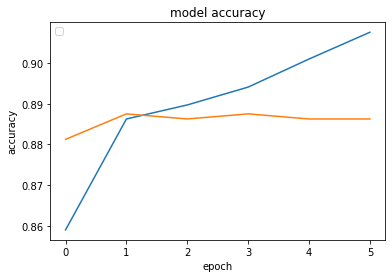

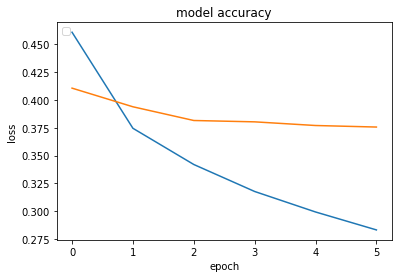

In [239]:
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

LSTM EVRİŞİMLİ SİNİR AĞLARI SINIFLANDIRMA

In [240]:

from keras.layers import Conv1D
model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [241]:
print(model.summary())

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 100, 100)          1063600   
                                                                 
 conv1d_5 (Conv1D)           (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d_5 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_14 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1,127,857
Trainable params: 64,257
Non-trainable params: 1,063,600
_________________________________________________________________
None


In [242]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)
score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/6
25/25 [==============================] - 3s 119ms/step - loss: 0.4240 - acc: 0.8769 - val_loss: 0.3521 - val_acc: 0.8863
Epoch 2/6
25/25 [==============================] - 3s 106ms/step - loss: 0.3246 - acc: 0.8881 - val_loss: 0.3391 - val_acc: 0.8900
Epoch 3/6
25/25 [==============================] - 3s 107ms/step - loss: 0.2819 - acc: 0.8900 - val_loss: 0.3270 - val_acc: 0.8913
Epoch 4/6
25/25 [==============================] - 3s 106ms/step - loss: 0.2483 - acc: 0.8984 - val_loss: 0.3104 - val_acc: 0.8900
Epoch 5/6
25/25 [==============================] - 3s 109ms/step - loss: 0.2185 - acc: 0.9141 - val_loss: 0.3209 - val_acc: 0.8913
Epoch 6/6
32/32 [==============================] - 0s 12ms/step - loss: 0.2659 - acc: 0.9041


In [243]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.26588988304138184
Test Accuracy: 0.9040958881378174


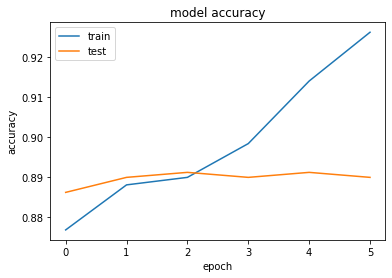

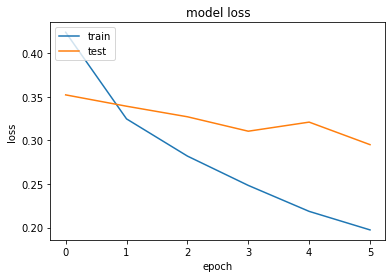

In [244]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

TEKRARLAYAN SİNİR AĞI MODELİ İLE METİN SINIFLANDIRMA

In [245]:
from tensorflow.keras.layers import LSTM
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [246]:
print(model.summary())

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 100, 100)          1063600   
                                                                 
 lstm_3 (LSTM)               (None, 128)               117248    
                                                                 
 dense_15 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1,180,977
Trainable params: 117,377
Non-trainable params: 1,063,600
_________________________________________________________________
None


In [247]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)
score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/6
25/25 [==============================] - 11s 385ms/step - loss: 0.4967 - acc: 0.8537 - val_loss: 0.3440 - val_acc: 0.8888
Epoch 2/6
25/25 [==============================] - 9s 359ms/step - loss: 0.3591 - acc: 0.8834 - val_loss: 0.3492 - val_acc: 0.8888
Epoch 3/6
25/25 [==============================] - 9s 358ms/step - loss: 0.3598 - acc: 0.8844 - val_loss: 0.3549 - val_acc: 0.8888
Epoch 4/6
25/25 [==============================] - 9s 359ms/step - loss: 0.3669 - acc: 0.8844 - val_loss: 0.3493 - val_acc: 0.8888
Epoch 5/6
25/25 [==============================] - 9s 359ms/step - loss: 0.3590 - acc: 0.8844 - val_loss: 0.3497 - val_acc: 0.8888
Epoch 6/6
32/32 [==============================] - 2s 65ms/step - loss: 0.3279 - acc: 0.9021


In [248]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.32791125774383545
Test Accuracy: 0.9020978808403015


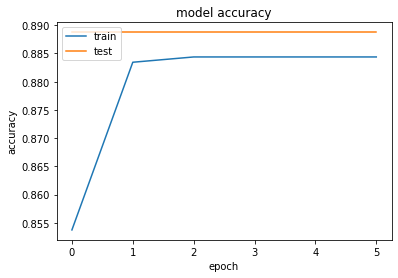

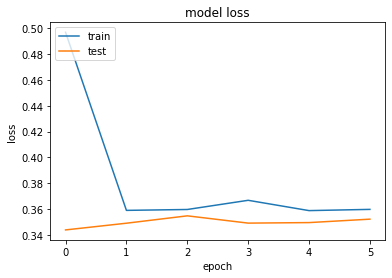

In [249]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [254]:
instance = X[150]
print(instance)

 BarcaPrincipal already bookmarked your previous tweet ever since just dey wait till the final make you fulfill that promise boss cos Argentina is winning the world cup


In [255]:
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

model.predict(instance)

1/1 [==============================] - 0s 27ms/step


array([[0.85456914]], dtype=float32)